# Phi-4 MultiModal - Tested! 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/designingwithml/blogposts/blob/main/notebooks/modelevals/gemma/gemma-3.ipynb)

# Gemma 3 MultiModal

> Note: Gemma 3 is released with specific dependencies. Install them in order:

```bash
pip install git+https://github.com/huggingface/transformers@v4.49.0-Gemma-3
torch>=2.0.0
pillow>=9.5.0
```

We will cover:

- Text generation
- Image description/captioning
- OCR
- Function Calling


In [1]:
! pip install -qq git+https://github.com/huggingface/transformers@v4.49.0-Gemma-3 torch pillow accelerate>=0.26.0

/bin/bash: /home/victordibia/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:

import requests
import torch
import os
from PIL import Image
from transformers import AutoProcessor, Gemma3ForConditionalGeneration, pipeline
from IPython.display import display, HTML, Markdown

# Load the model and processor
model_path = "google/gemma-3-12b-it"   
pipe = pipeline(
    "image-text-to-text",
    model= model_path,
    device="cuda",
    torch_dtype=torch.bfloat16
)

/home/victordibia/miniconda3/envs/gemma/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/victordibia/miniconda3/envs/gemma/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 5/5 [00:01<00:00,  4.56it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda


In [3]:
import torch
from transformers import pipeline

# Set up the pipeline
pipe = pipeline(
    "image-text-to-text",
    model="google/gemma-3-4b-it",  # "google/gemma-3-12b-it", "google/gemma-3-27b-it"
    device="cuda",
    torch_dtype=torch.bfloat16
)

def gemma3_multimodal_interface(
    pipe,
    system_prompt,
    content_list,
    max_new_tokens=1000
):
    """
    Creates the appropriate prompt and processes inputs for Gemma 3 multimodal model using the pipeline API.
    """
    import time
    
    # Format messages for Gemma 3
    messages = []
    
    # Add system prompt if provided
    if system_prompt:
        messages.append({
            "role": "system",
            "content": [{"type": "text", "text": system_prompt}]
        })
    
    # Track user content
    user_content = []
    
    # Process content list
    for item in content_list:
        item_type = item['type']
        
        if item_type == 'text':
            user_content.append({"type": "text", "text": item['content']})
        elif item_type == 'image':
            user_content.append({"type": "image", "url": item['content']})
    
    # Add user message
    messages.append({
        "role": "user",
        "content": user_content
    })
    
    # Track timing information
    timing_info = {}
 
    
    # Run inference with the pipeline
    timing_info['start_total'] = time.time()
    output = pipe(text=messages, max_new_tokens=max_new_tokens)
    timing_info['end_total'] = time.time()
    timing_info['total_time'] = timing_info['end_total'] - timing_info['start_total']
    
    # Get the response content
    response = output[0]["generated_text"][-1]["content"]
    
    return response, timing_info

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]
Device set to use cuda


In [4]:

def run_and_print_results(system_prompt, content_list, name="Example"):
    # Set up CSS for better text wrapping
    display(HTML("""
    <style>
    .jp-OutputArea-output {
        overflow-x: auto;
        white-space: pre-wrap;
        word-wrap: break-word;
    }
    .output_text {
        white-space: pre-wrap !important;
    }
    </style>
    """))

    display(Markdown(f"## {name}"))

    display(Markdown("### Query:"))
    display(Markdown(f"```\n{content_list[-1]['content']}\n```"))

    # Run the model
    response, timing = gemma3_multimodal_interface(
        pipe, system_prompt, content_list, max_new_tokens=1000
    )

    display(Markdown("### Response:"))
    display(Markdown(f"```\n{response}\n```"))

    display(Markdown("### Timing Information:"))
    timing_md = f"""
    - **Total time:** {timing['total_time']:.4f} seconds
    """
    display(Markdown(timing_md))

    return response, timing

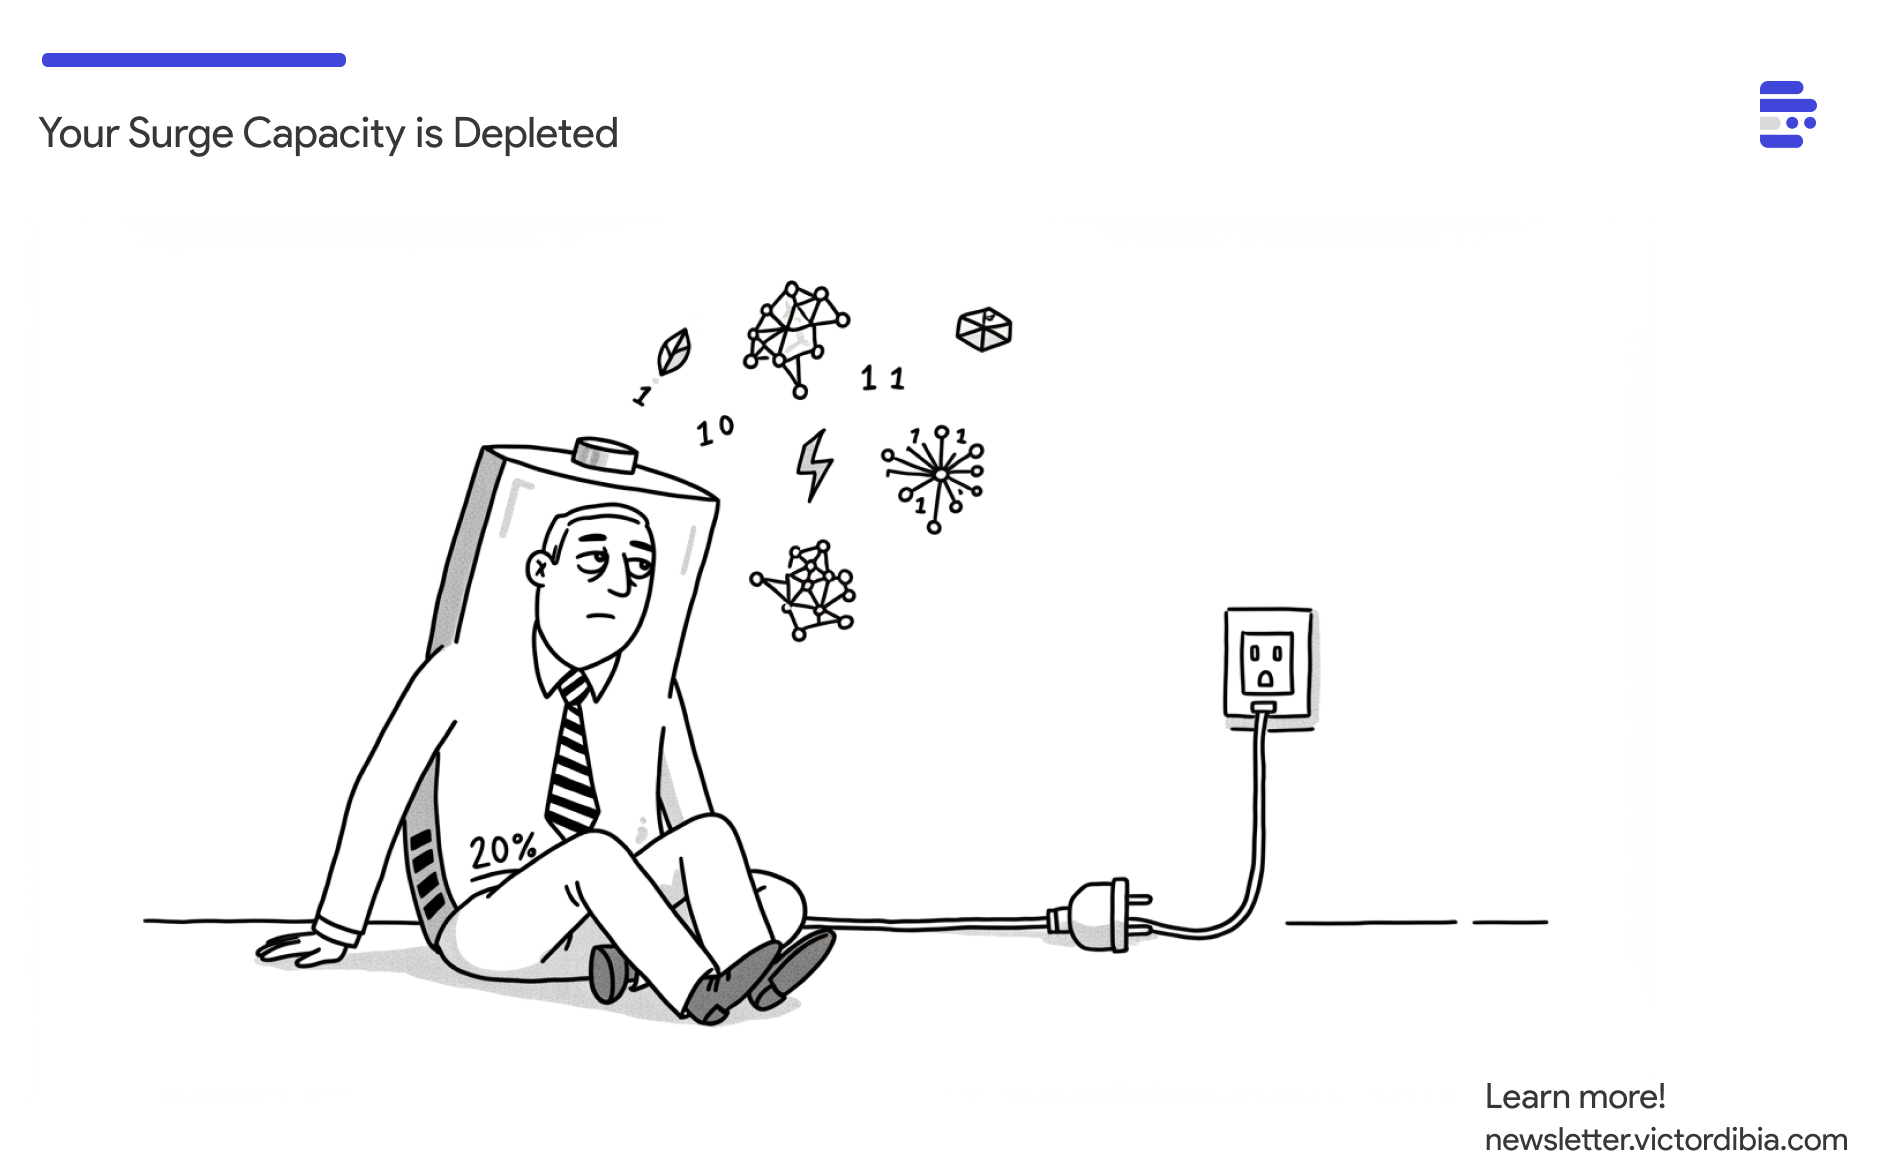

## Example 2.1: Image description

### Query:

```
What is shown in this image?
```

### Response:

```
Here's an analysis of what's shown in the image:

**Overall Concept:**

The image is a cartoon-style illustration conveying the feeling of burnout or being overwhelmed. It uses a metaphorical representation of "surge capacity" being depleted.

**Detailed Description:**

*   **Central Figure:** A man is sitting on the ground, slumped over, with a box-like structure (possibly representing his mind or workload) partially covering him. He looks exhausted and distressed.
*   **Percentage:** A "20%" sign is visible on his leg, indicating a low level of energy or capacity.
*   **Electrical Imagery:** There are several electrical symbols (like circuits, wires, and lightning bolts) swirling around the man's head, suggesting a drain of energy or mental resources. The numbers "10" and "11" are also present, possibly representing a high level of demand or pressure.
*   **Outlet:** A standard electrical outlet is plugged into the wall, connected to a cable leading to the man. This represents the source of the energy being drained.
*   **Text:** The text "Your Surge Capacity is Depleted" is prominently displayed at the top, and "Learn more! newsletter.victordibia.com" is at the bottom.

**Interpretation:**

The image is a visual metaphor for feeling overwhelmed, exhausted, and depleted of energy – a state where one's ability to handle demands is significantly reduced. It’s likely promoting a message about recognizing and addressing burnout or the need for rest and recovery.

Do you want me to focus on a specific aspect of the image, such as the symbolism or the message it's trying to convey?
```

### Timing Information:


    - **Total time:** 22.3621 seconds
    

('Here\'s an analysis of what\'s shown in the image:\n\n**Overall Concept:**\n\nThe image is a cartoon-style illustration conveying the feeling of burnout or being overwhelmed. It uses a metaphorical representation of "surge capacity" being depleted.\n\n**Detailed Description:**\n\n*   **Central Figure:** A man is sitting on the ground, slumped over, with a box-like structure (possibly representing his mind or workload) partially covering him. He looks exhausted and distressed.\n*   **Percentage:** A "20%" sign is visible on his leg, indicating a low level of energy or capacity.\n*   **Electrical Imagery:** There are several electrical symbols (like circuits, wires, and lightning bolts) swirling around the man\'s head, suggesting a drain of energy or mental resources. The numbers "10" and "11" are also present, possibly representing a high level of demand or pressure.\n*   **Outlet:** A standard electrical outlet is plugged into the wall, connected to a cable leading to the man. This r

In [5]:

# Example 2: Image description
# Download an image
image_url = 'https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fb71d0075-5e75-41a3-88e3-90b2292de534_1901x1163.png'

image = Image.open(requests.get(image_url, stream=True).raw)
display(image)

system_prompt = "You are a helpful assistant that can analyze images."
content_list = [
    {
        'type': 'image',
        'content': image,
        'role': 'user'
    },
    {
        'type': 'text',
        'content': 'What is shown in this image?',
        'role': 'user'
    }
]

run_and_print_results(system_prompt, content_list, "Example 2.1: Image description")


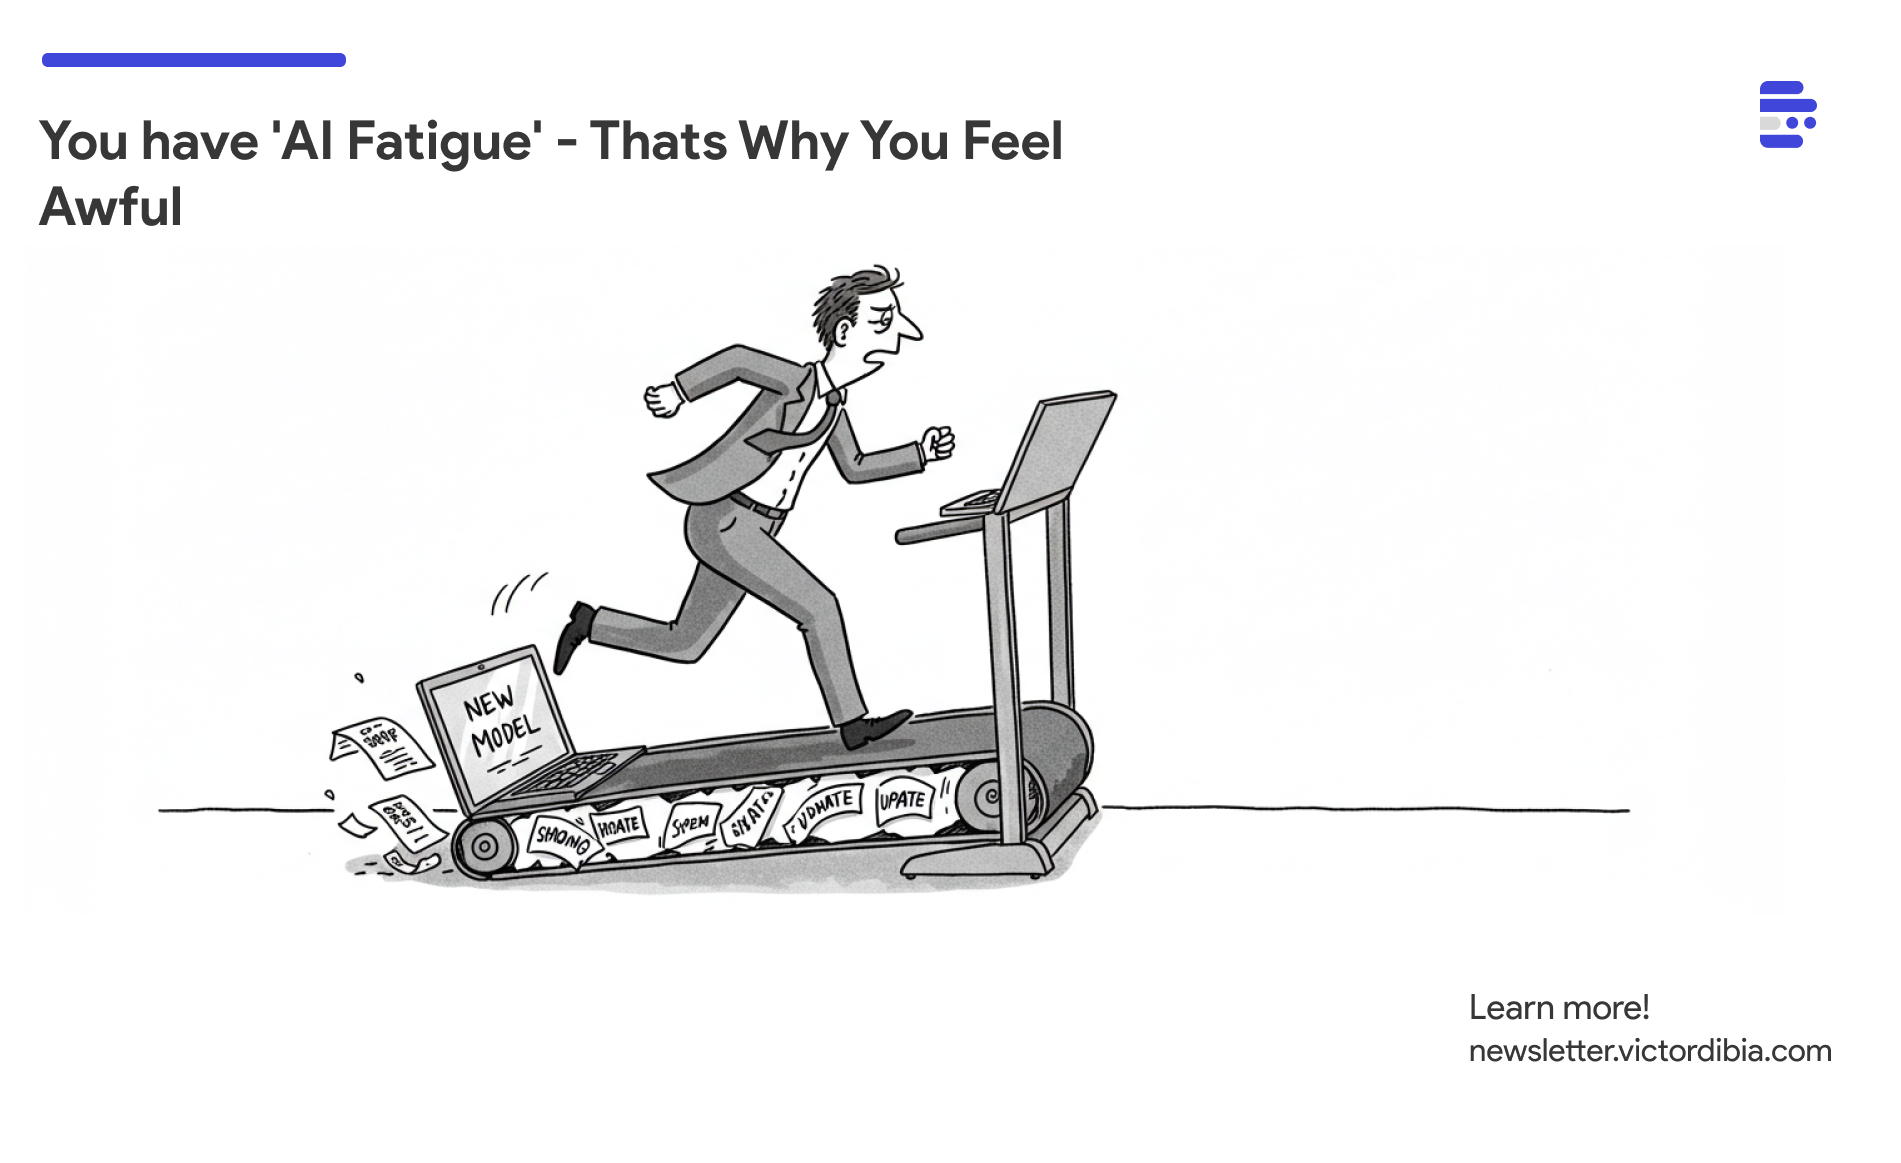

## Example 2.2: Image description

### Query:

```
What is shown in this image?
```

### Response:

```
Here's an analysis of what's shown in the image:

**Overall Impression:**

The image is a cartoon-style illustration that visually represents the feeling of "AI fatigue." It's a humorous take on the rapid pace of advancements and changes in the field of artificial intelligence.

**Detailed Description:**

*   **Central Figure:** A man in a business suit is running frantically on a treadmill. He's clearly exhausted, with his arms raised in a gesture of desperation.
*   **Treadmill:** The treadmill is covered in labels like "Open," "Search," "Update," "Format," "Show," and "Train." These represent the various tasks and processes involved in working with AI models.
*   **"New Model" Cart:** A small cart labeled "New Model" is being pulled along by the treadmill, suggesting a constant stream of new AI models and technologies.
*   **Background:** There are numerous scattered documents and icons floating in the background, symbolizing the overwhelming amount of information and tasks associated with AI.
*   **Text:** The text at the top reads "You have 'AI Fatigue' - That's Why You Feel Awful." and at the bottom directs the viewer to a website: newsletter.victordibia.com.

**Interpretation:**

The image is a metaphor for the feeling of being overwhelmed and exhausted by the constant need to learn, adapt, and keep up with the latest developments in AI. It suggests that the rapid pace of innovation can lead to burnout and a sense of being perpetually behind.

Do you want me to zoom in on a specific part of the image or analyze a particular element in more detail?
```

### Timing Information:


    - **Total time:** 21.5833 seconds
    

('Here\'s an analysis of what\'s shown in the image:\n\n**Overall Impression:**\n\nThe image is a cartoon-style illustration that visually represents the feeling of "AI fatigue." It\'s a humorous take on the rapid pace of advancements and changes in the field of artificial intelligence.\n\n**Detailed Description:**\n\n*   **Central Figure:** A man in a business suit is running frantically on a treadmill. He\'s clearly exhausted, with his arms raised in a gesture of desperation.\n*   **Treadmill:** The treadmill is covered in labels like "Open," "Search," "Update," "Format," "Show," and "Train." These represent the various tasks and processes involved in working with AI models.\n*   **"New Model" Cart:** A small cart labeled "New Model" is being pulled along by the treadmill, suggesting a constant stream of new AI models and technologies.\n*   **Background:** There are numerous scattered documents and icons floating in the background, symbolizing the overwhelming amount of information a

In [6]:

# Example 2: Image description
# Download another image
image_url = 'https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Faa0f402f-7438-4620-9708-2fe9e220bce6_1901x1163.png'

image = Image.open(requests.get(image_url, stream=True).raw)
display(image)

system_prompt = "You are a helpful assistant that can analyze images."
content_list = [
    {
        'type': 'image',
        'content': image,
        'role': 'user'
    },
    {
        'type': 'text',
        'content': 'What is shown in this image?',
        'role': 'user'
    }
]

run_and_print_results(system_prompt, content_list, "Example 2.2: Image description")


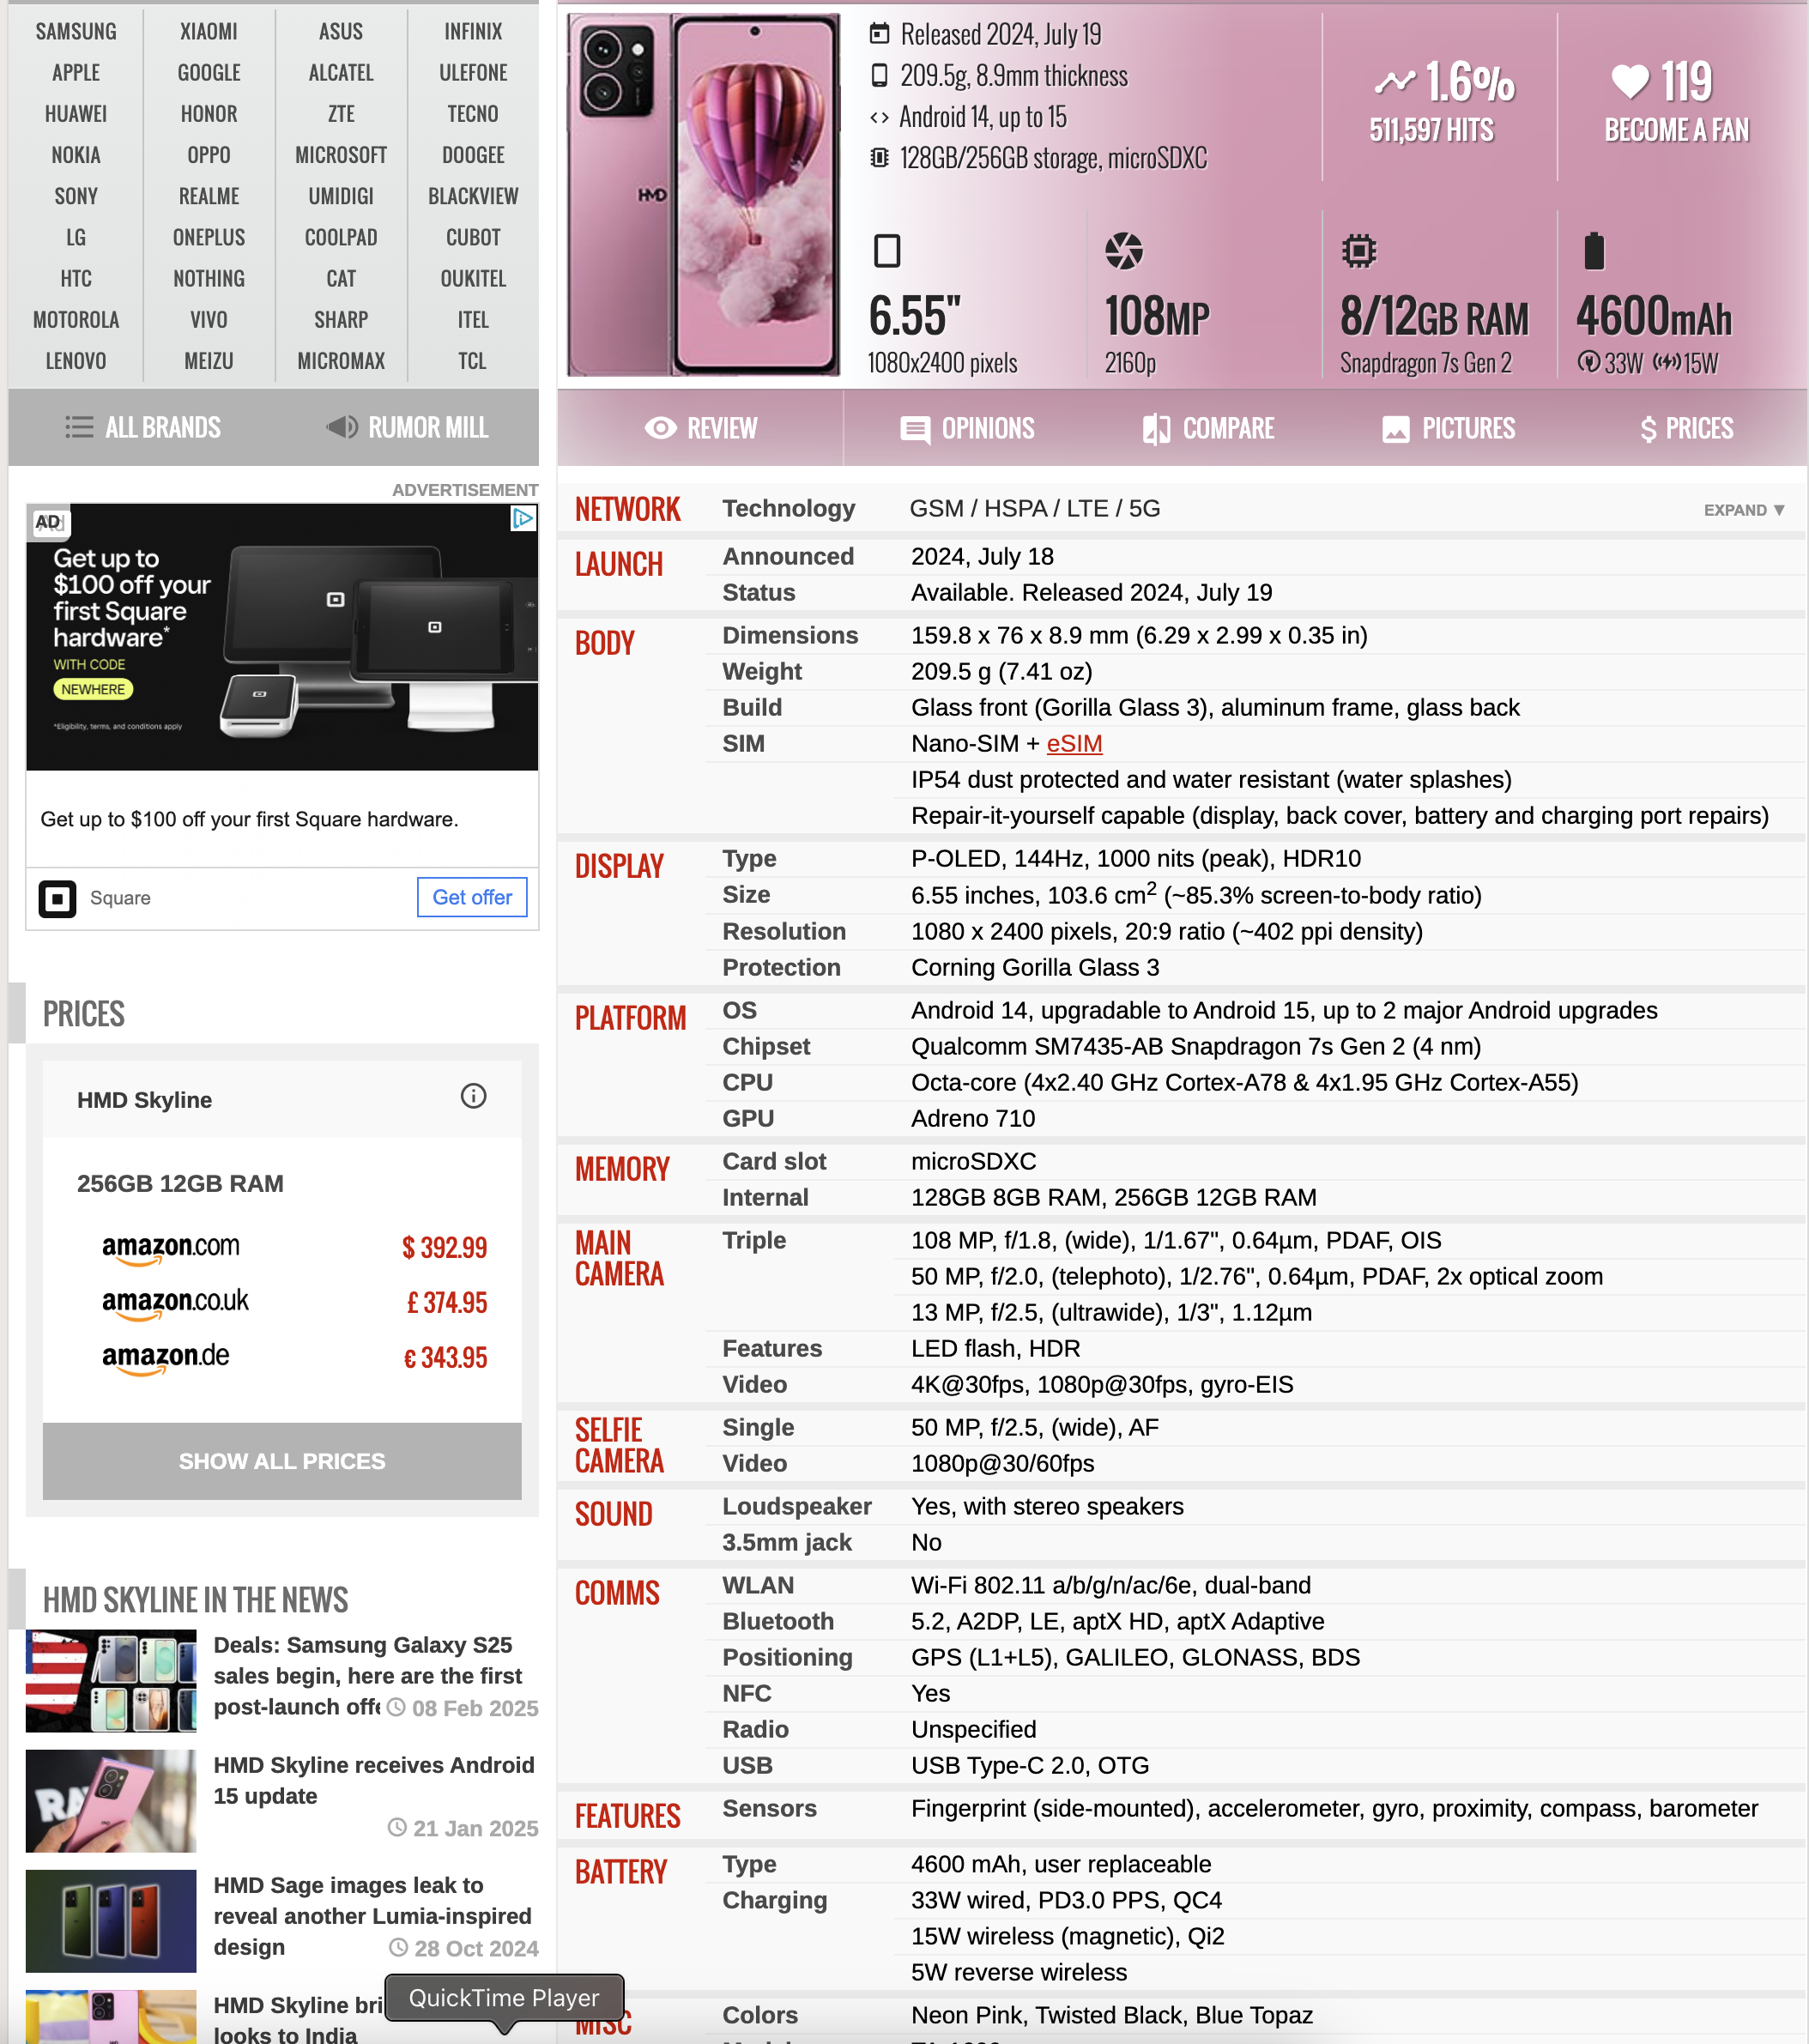

## Example 2.3: OCR

### Query:

```
Extract ALL the text (OCR) from this image and render in a neat markdown TABLE format
```

### Response:

```
Here's the text extracted from the image, presented in a markdown table:

| Feature          | Value                     |
|------------------|---------------------------|
| **Model**         | H |
| **Released**      | 2024, July 19            |
| **OS**            | Android 14, up to 15      |
| **Storage**       | 128GB/256GB storage, microSDXC |
| **Dimensions**    | 159.8 x 76.9 x 8.9 mm (6.29 x 2.99 x 0.35 in) |
| **Weight**        | 209.5 g (7.41 oz)         |
| **Build**         | Glass front (Gorilla Glass 3), aluminum frame, glass back |
| **SIM**           | Nano-SIM + eSIM            |
| **IP Rating**     | IP54 dust protected and water resistant (water splashes) |
| **Repair**        | Repair-it-yourself capable (display, back cover, battery and charging port repairs) |
| **Display**       | Type                      |
|                   | Size                      | 6.55 inches, 103.6 cm² (-85.3% screen-to-body ratio) |
|                   | Resolution                | 1080 x 2400 pixels, 209 r/o (402 ppi density) |
|                   | Protection                | Corning Gorilla Glass 3       |
| **Platform**      | OS                        | Android 14                  |
|                   | CPU                       | Qualcomm Snapdragon 7 Gen 2 |
|                   | GPU                       | Adreno 730                   |
| **Connectivity**  | Celluler                   | GSM / HSPA / LTE / 5G          |
|                   | Wi-Fi                     | 802.11 a/b/g/n/ac, 6GHz, dual-band, Wi-Fi Direct, hotspot |
|                   | Bluetooth                  | 5.3                       |
|                   | GPS                        | GPS, GLONASS, BDS, GALILEO   |
|                   | NFC                        | Yes                        |
| **Sensors**       |                          | Fingerprint (under display), accelerometer, gyro, proximity, compass |
| **Battery**       | Capacity                   | 4600mAh                    |
|                   | Charging                  | 65W wired                   |
| **Colors**        |                          | Black, Green, White           |
| **Price**         |                          | Starting at $499.99           |

**Additional Text:**

*   Get up to $100 off your first Square hardware.
*   Get offer
*   Rumor Mill
*   1.6%
*   511,597 hits
*   Become a fan
*   © 2024 All Rights Reserved.
*   Square
```

### Timing Information:


    - **Total time:** 41.1340 seconds
    

("Here's the text extracted from the image, presented in a markdown table:\n\n| Feature          | Value                     |\n|------------------|---------------------------|\n| **Model**         | H |\n| **Released**      | 2024, July 19            |\n| **OS**            | Android 14, up to 15      |\n| **Storage**       | 128GB/256GB storage, microSDXC |\n| **Dimensions**    | 159.8 x 76.9 x 8.9 mm (6.29 x 2.99 x 0.35 in) |\n| **Weight**        | 209.5 g (7.41 oz)         |\n| **Build**         | Glass front (Gorilla Glass 3), aluminum frame, glass back |\n| **SIM**           | Nano-SIM + eSIM            |\n| **IP Rating**     | IP54 dust protected and water resistant (water splashes) |\n| **Repair**        | Repair-it-yourself capable (display, back cover, battery and charging port repairs) |\n| **Display**       | Type                      |\n|                   | Size                      | 6.55 inches, 103.6 cm² (-85.3% screen-to-body ratio) |\n|                   | Resolution 

In [7]:

# Example 2.3: OCR
phone_image_path = '../phi4/downloads/phone_specs.png'
# Load image
phone_image = Image.open(phone_image_path)
display(phone_image)

system_prompt = "You are a helpful assistant that perform OCR and carefully extract all text from an image."
content_list = [
    {
        'type': 'image',
        'content': phone_image,
        'role': 'user'
    },
    {
        'type': 'text',
        'content': 'Extract ALL the text (OCR) from this image and render in a neat markdown TABLE format',
        'role': 'user'
    }
]

run_and_print_results(system_prompt, content_list, "Example 2.3: OCR")


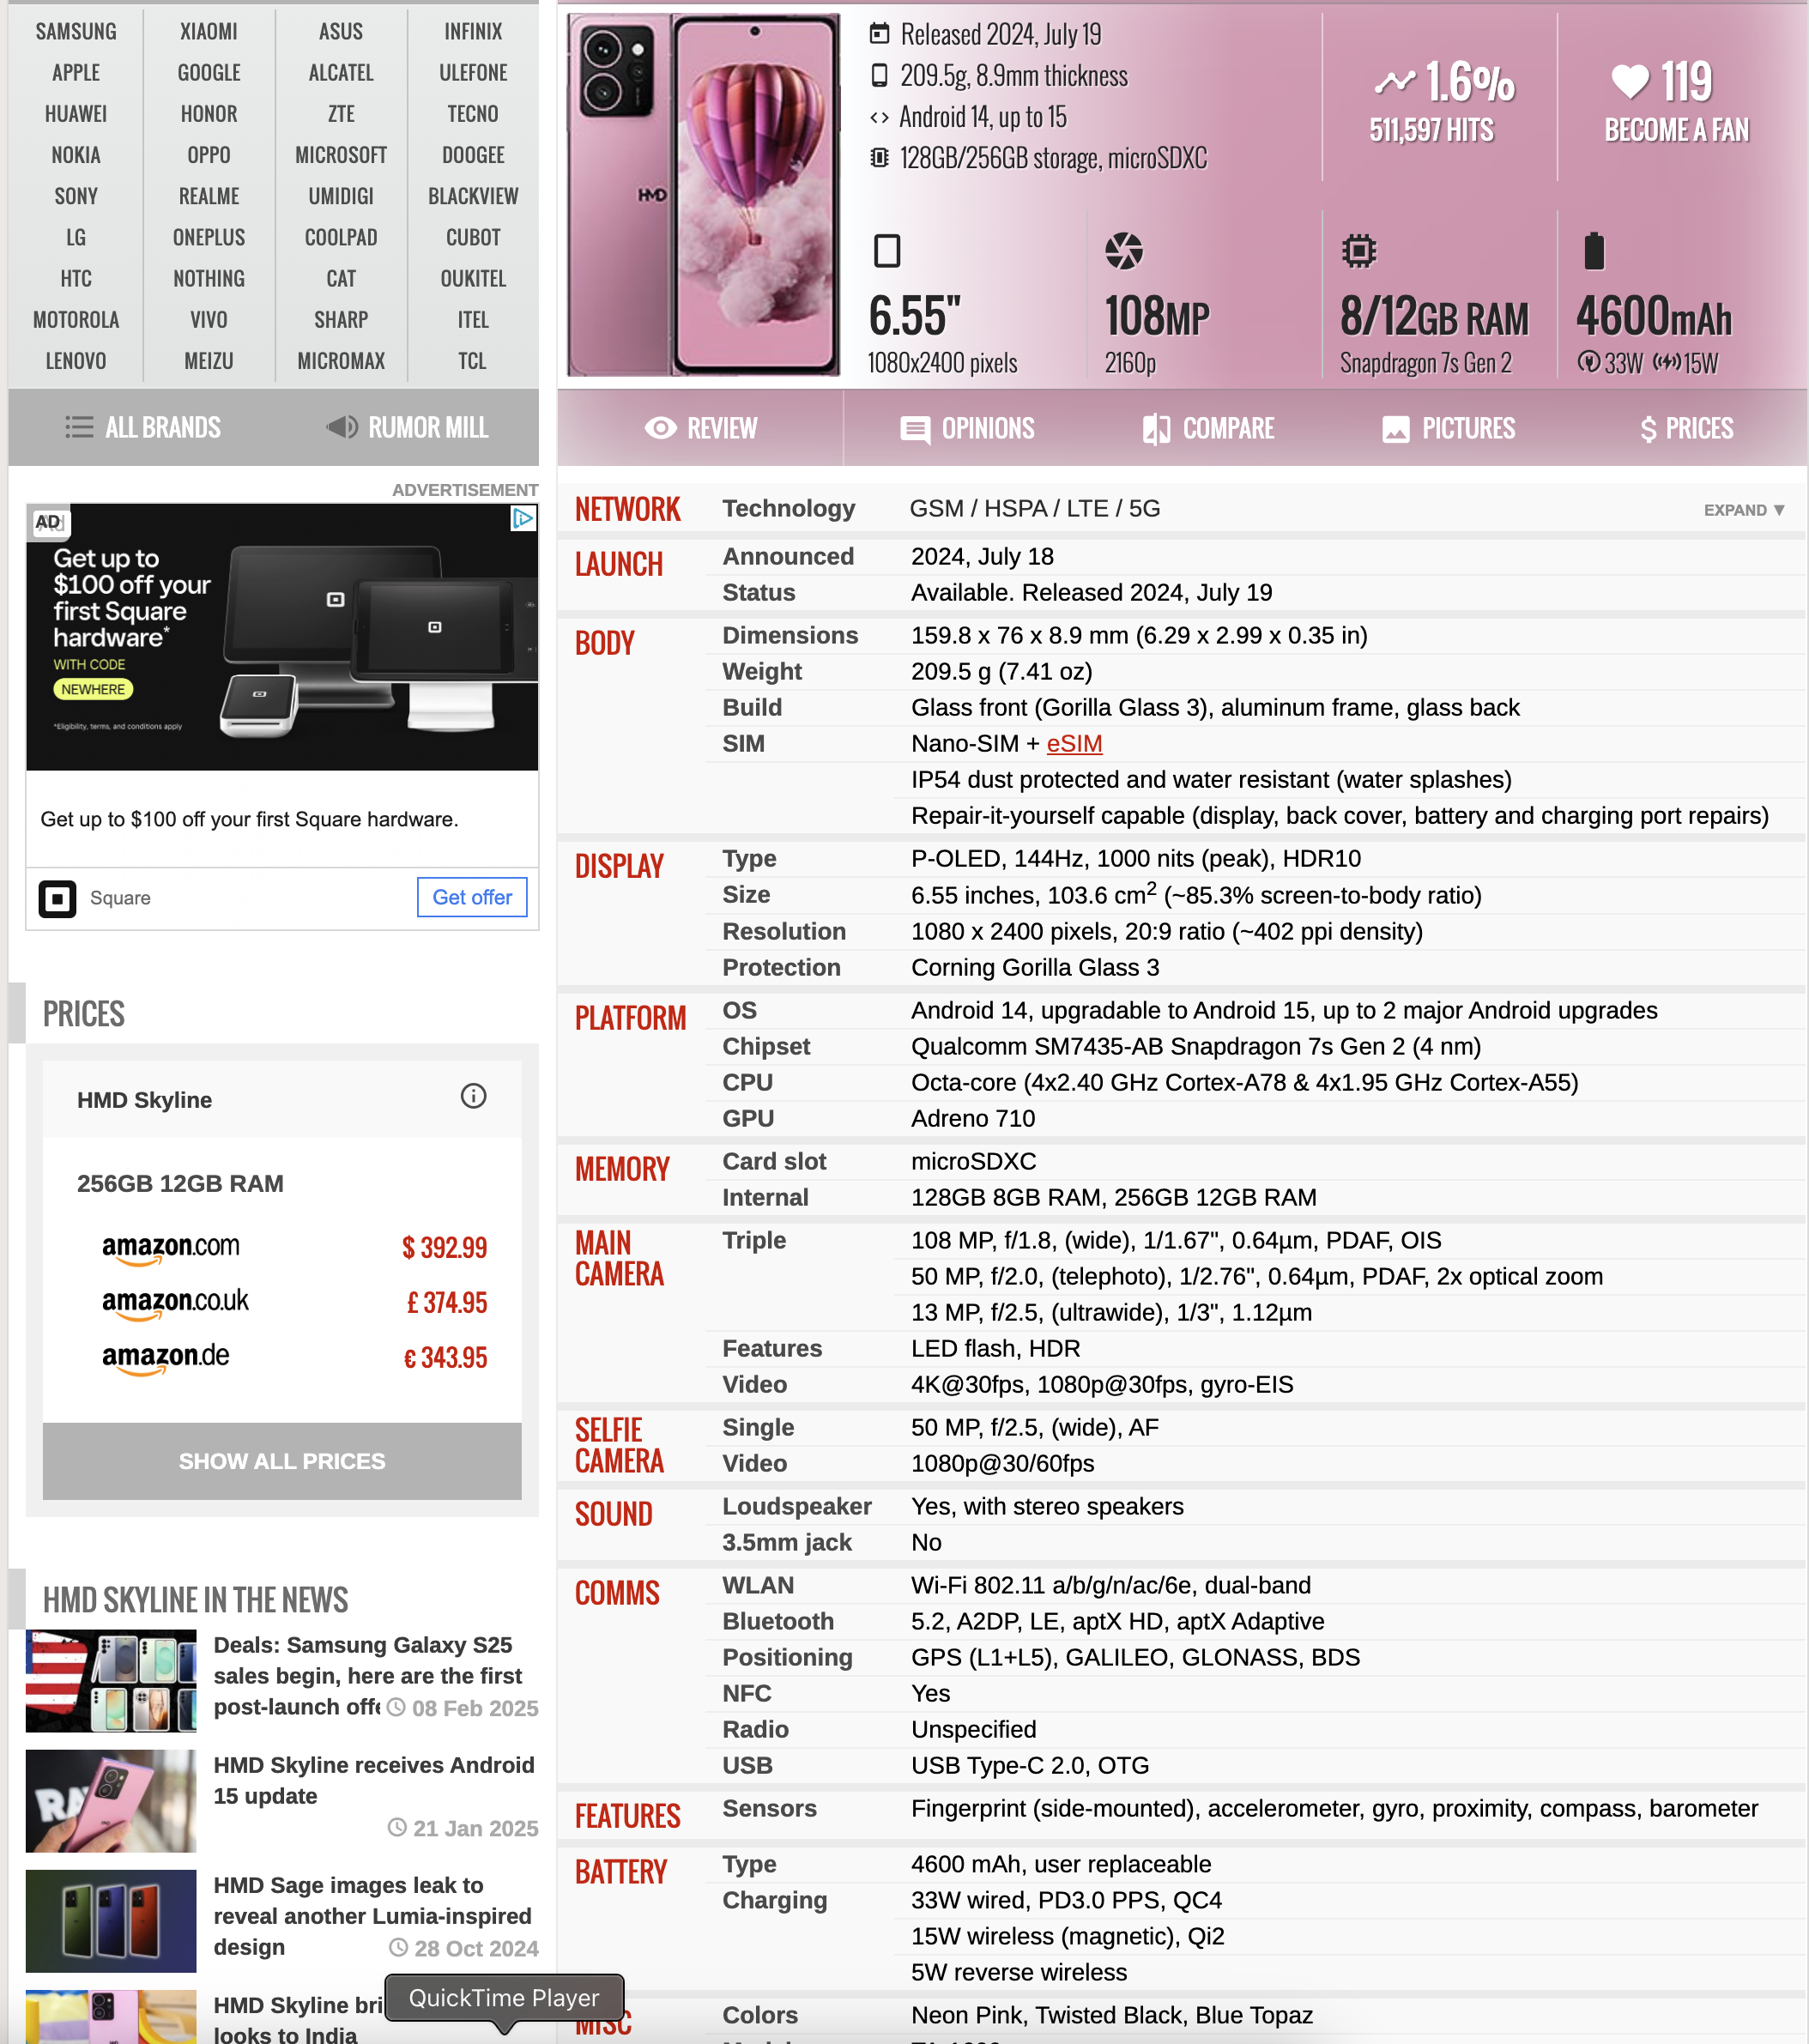

## Example 6.1: Visual Understanding for Product Specs

### Query:

```
What are the main specifications of this phone shown in the image? Please organize them by category (display, camera, processor, etc).
```

### Response:

```
Okay, here’s a breakdown of the main specifications of the phone shown in the image, organized by category:

**General Information**

*   **Model:** Hoco IQoo
*   **Release Date:** 2024, July 18
*   **Available:** Available, Released 2024, July 19
*   **Website:** [https://www.poco.com/iqoo/](https://www.poco.com/iqoo/)

**Body**

*   **Dimensions:** 159.8 x 76.9 x 8.9 mm (6.29 x 2.99 x 0.35 in)
*   **Weight:** 209.5 g (7.42 oz)
*   **Build:** Glass front (Gorilla Glass 3), aluminum frame, glass back
*   **SIM:** Nano-SIM + eSIM
*   **Protection:** IP54 dust protected and water resistant (water splashes)

**Display**

*   **Type:** P-OLED, 144Hz, 1000 nits (peak)
*   **Size:** 6.55 inches, 103.6 cm² (~85.3% screen-to-body ratio)
*   **Resolution:** 1080 x 2400 pixels, 2090 PPI (~402 ppi density)
*   **Protection:** Corning Gorilla Glass 3
*   **Refresh Rate:** 120Hz

**Platform**

*   **OS:** Android 14, up to 15
*   **Chip:** Qualcomm Snapdragon 7 Gen 2
*   **CPU:** Octa-core (1x3.2 GHz Cortex-A715 & 3x2.8 GHz Cortex-A710 & 4x2.0 GHz Cortex-A510)
*   **GPU:** Adreno 730

**Memory**

*   **RAM:** 8/12GB
*   **Storage:** 128GB/256GB
*   **Card Slot:** microSDXC (dedicated slot)

**Camera**

*   **Rear:**
    *   **108MP** (wide)
    *   f/1.8, 26mm (ultrawide), PDAF, OIS
    *   2MP (macro)
    *   2MP (depth)
*   **Front:** 16MP (wide)
    *   f/2.4, 28mm (ultrawide)

**Network & Connectivity**

*   **Technology:** GSM / HSPA / LTE / 5G
*   **Speed:** 5G: Capable of speeds up to 3.5Gbps; LTE: Capable of speeds up to 1200Mbps; 3G: Capable of speeds up to 420Mbps; 2G: GPRS, EDGE

**Battery**

*   **Capacity:** 4600 mAh
*   **Charging:** 67W wired

**Other**

*   **Sensors:** Fingerprint (side-mounted), accelerometer, gyro, proximity, compass

---

Do you want me to delve deeper into any specific aspect of these specifications (e.g., camera details, processor performance, or battery charging speed)?
```

### Timing Information:


    - **Total time:** 46.9501 seconds
    

('Okay, here’s a breakdown of the main specifications of the phone shown in the image, organized by category:\n\n**General Information**\n\n*   **Model:** Hoco IQoo\n*   **Release Date:** 2024, July 18\n*   **Available:** Available, Released 2024, July 19\n*   **Website:** [https://www.poco.com/iqoo/](https://www.poco.com/iqoo/)\n\n**Body**\n\n*   **Dimensions:** 159.8 x 76.9 x 8.9 mm (6.29 x 2.99 x 0.35 in)\n*   **Weight:** 209.5 g (7.42 oz)\n*   **Build:** Glass front (Gorilla Glass 3), aluminum frame, glass back\n*   **SIM:** Nano-SIM + eSIM\n*   **Protection:** IP54 dust protected and water resistant (water splashes)\n\n**Display**\n\n*   **Type:** P-OLED, 144Hz, 1000 nits (peak)\n*   **Size:** 6.55 inches, 103.6 cm² (~85.3% screen-to-body ratio)\n*   **Resolution:** 1080 x 2400 pixels, 2090 PPI (~402 ppi density)\n*   **Protection:** Corning Gorilla Glass 3\n*   **Refresh Rate:** 120Hz\n\n**Platform**\n\n*   **OS:** Android 14, up to 15\n*   **Chip:** Qualcomm Snapdragon 7 Gen 2\n

In [8]:

# Example 6.1: Visual Understanding for Product Specs
# Load local files
phone_image_path = '../phi4/downloads/phone_specs.png'

# Load image
phone_image = Image.open(phone_image_path)
display(phone_image)

# Set up task
system_prompt = "You are a helpful tech assistant who can analyze product specifications."
content_list = [
    {
        'type': 'image',
        'content': phone_image,
        'role': 'user'
    },
    {
        'type': 'text',
        'content': "What are the main specifications of this phone shown in the image? Please organize them by category (display, camera, processor, etc).",
        'role': 'user'
    }
]

run_and_print_results(system_prompt, content_list, "Example 6.1: Visual Understanding for Product Specs")